In [396]:
import sys 
print(sys.version)

3.7.3 (default, Mar 27 2019, 16:54:48) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


In [397]:
import os
import copy
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
#from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM, BertConfig
from bertModel import BertClassification, dense_opt
from datasets import text_dataset, financialPhraseBankDataset
import argparse
from sklearn.metrics import f1_score

In [398]:
labels = {0:'neutral', 1:'positive',2:'negative'}
num_labels= len(labels)
vocab ="finance-uncased"
vocab_path = '/Users/svetlana/Downloads/analyst_tone-2/vocab' 
pretrained_weights_path ='/Users/svetlana/Downloads/analyst_tone-2/pretrained_weights'
fine_tuned_weight_path = '/Users/svetlana/Downloads/analyst_tone-2/fine_tuned.pth'   
max_seq_length = 256
device=torch.device("cpu")

In [399]:
model = BertClassification(weight_path = pretrained_weights_path, 
                           num_labels=num_labels, vocab=vocab)

/Users/svetlana/finBERT/from git/bertModel.py:31: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(self.classifier.weight)


In [400]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
bert.embeddings.word_embeddings.weight 	 torch.Size([30873, 768])
bert.embeddings.position_embeddings.weight 	 torch.Size([512, 768])
bert.embeddings.token_type_embeddings.weight 	 torch.Size([2, 768])
bert.embeddings.LayerNorm.weight 	 torch.Size([768])
bert.embeddings.LayerNorm.bias 	 torch.Size([768])
bert.encoder.layer.0.attention.self.query.weight 	 torch.Size([768, 768])
bert.encoder.layer.0.attention.self.query.bias 	 torch.Size([768])
bert.encoder.layer.0.attention.self.key.weight 	 torch.Size([768, 768])
bert.encoder.layer.0.attention.self.key.bias 	 torch.Size([768])
bert.encoder.layer.0.attention.self.value.weight 	 torch.Size([768, 768])
bert.encoder.layer.0.attention.self.value.bias 	 torch.Size([768])
bert.encoder.layer.0.attention.output.dense.weight 	 torch.Size([768, 768])
bert.encoder.layer.0.attention.output.dense.bias 	 torch.Size([768])
bert.encoder.layer.0.attention.output.LayerNorm.weight 	 torch.Size([768])
bert.encoder.layer.0.attention.outp

bert.encoder.layer.9.attention.self.key.bias 	 torch.Size([768])
bert.encoder.layer.9.attention.self.value.weight 	 torch.Size([768, 768])
bert.encoder.layer.9.attention.self.value.bias 	 torch.Size([768])
bert.encoder.layer.9.attention.output.dense.weight 	 torch.Size([768, 768])
bert.encoder.layer.9.attention.output.dense.bias 	 torch.Size([768])
bert.encoder.layer.9.attention.output.LayerNorm.weight 	 torch.Size([768])
bert.encoder.layer.9.attention.output.LayerNorm.bias 	 torch.Size([768])
bert.encoder.layer.9.intermediate.dense.weight 	 torch.Size([3072, 768])
bert.encoder.layer.9.intermediate.dense.bias 	 torch.Size([3072])
bert.encoder.layer.9.output.dense.weight 	 torch.Size([768, 3072])
bert.encoder.layer.9.output.dense.bias 	 torch.Size([768])
bert.encoder.layer.9.output.LayerNorm.weight 	 torch.Size([768])
bert.encoder.layer.9.output.LayerNorm.bias 	 torch.Size([768])
bert.encoder.layer.10.attention.self.query.weight 	 torch.Size([768, 768])
bert.encoder.layer.10.attention.s

In [401]:
model.load_state_dict(torch.load(fine_tuned_weight_path, map_location=device))
model.to(device)

BertClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30873, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )


# 0 is neutral, 1 is positive, and 2 is negative 

In [402]:
import glob
import csv
import pandas as pd
text_path = '/Users/svetlana/Desktop/Creation/*'
files = glob.glob(text_path)

def get_split(text1):
  l_total = []
  l_parcial = []
  if len(text1.split())//75 >0:
    n = len(text1.split())//75
  else: 
    n = 1
  for w in range(n):
    if w == 0:
      l_parcial = text1.split()[:100]
      l_total.append(" ".join(l_parcial))
    else:
      l_parcial = text1.split()[w*75:w*75 + 100]
      l_total.append(" ".join(l_parcial))
  return l_total

In [403]:
sentences = []
length_sent = []
for file in files:
    with open(file) as f:
        sentence = f.read().strip().split('\n')
        length = len(sentence)
        length = np.log(length)
    sentences.append(sentence)
    length_sent.append(length)

In [404]:
sentences

[['EL DORADO, Ark.--(BUSINESS WIRE)--Oct. 10, 2018-- Murphy Oil Corporation (NYSE: MUR) announced today that its wholly owned subsidiary, Murphy Exploration & Production Company - USA, has entered into a definitive agreement to form a new joint venture company with Petrobras America Inc. (“PAI”), a subsidiary of Petrobras (NYSE: PBR). The joint venture company will be comprised of Gulf of Mexico producing assets from Murphy and PAI with Murphy overseeing the operations. The transaction will have an effective date of October 1, 2018 and is expected to close by year-end 2018. ',
  'Both companies will contribute all their current producing Gulf of Mexico assets to the joint venture, which will be owned 80 percent by Murphy and 20 percent by PAI. The transaction excludes exploration blocks from both companies, with the exception of PAI’s blocks that hold deep exploration rights. Murphy will pay cash consideration of $900 million to PAI, subject to normal closing adjustments. Additionally,

In [405]:
import transformers
from transformers import BertTokenizer
tokenizer = BertTokenizer(vocab_file = vocab_path, do_lower_case = True, 
                          do_basic_tokenize = True)
from torch import Tensor

In [406]:
def sentiment_function(sentences):
    for sent in sentences:
        encoded_data = tokenizer.batch_encode_plus(
            sentences, add_special_tokens = True,
            return_attention_mask = True,
            max_length = max_seq_length,
            pad_to_max_length = True,
            return_tensors = 'pt')
        
    labels = torch.empty(len(sentences), dtype=torch.long)
    input_ids = encoded_data['input_ids']
    attention_masks = encoded_data['attention_mask']
    labels = torch.tensor(labels)
    
    dataset = TensorDataset(input_ids, attention_masks, labels)
    
    batch_size = 32
    
    dataloader = DataLoader(
        dataset, 
        sampler = RandomSampler(dataset),
        batch_size=batch_size)
    
    def predict(dataloader_):
        model.eval()
        predictions = []
        for batch in dataloader:
            batch = tuple(t.to(device) for t in batch)
            inputs = {'input_ids': batch[0],
                      'attention_mask': batch[1],
                      'labels': batch[2],
                     }
            with torch.no_grad():
                outputs = model(**inputs)
        
            outputs = F.softmax(outputs,dim=1)
            logits = outputs[0]
            logits = logits.detach().cpu().numpy()
        
            predictions.append(outputs)
        
        predictions = np.concatenate(predictions, axis = 0)
    
        return predictions
    
    pred = predict(dataloader_ = dataloader)
    
    positives = 0
    negatives = 0
    neutrals = 0
    sentiment = []
    for i in range(len(pred)):
        pred_labels_i = np.argmax(pred[i]).flatten()
        sentiment.append(pred_labels_i[0])
        if pred_labels_i[0] == 1:
            positives+=1
        elif pred_labels_i[0] == 2:
            negatives+=1
        elif pred_labels_i[0] == 0:
            neutrals+=1
    return(positives, negatives, neutrals) 

In [407]:
for i in sentences[0]:
    print(i)

EL DORADO, Ark.--(BUSINESS WIRE)--Oct. 10, 2018-- Murphy Oil Corporation (NYSE: MUR) announced today that its wholly owned subsidiary, Murphy Exploration & Production Company - USA, has entered into a definitive agreement to form a new joint venture company with Petrobras America Inc. (“PAI”), a subsidiary of Petrobras (NYSE: PBR). The joint venture company will be comprised of Gulf of Mexico producing assets from Murphy and PAI with Murphy overseeing the operations. The transaction will have an effective date of October 1, 2018 and is expected to close by year-end 2018. 
Both companies will contribute all their current producing Gulf of Mexico assets to the joint venture, which will be owned 80 percent by Murphy and 20 percent by PAI. The transaction excludes exploration blocks from both companies, with the exception of PAI’s blocks that hold deep exploration rights. Murphy will pay cash consideration of $900 million to PAI, subject to normal closing adjustments. Additionally, PAI wil

In [408]:
positive_sent = []
negative_sent = []
neutral_sent = []
for sentence in sentences:
    a = sentiment_function(sentence)
    positive_sent.append(a[0])
    negative_sent.append(a[1])
    neutral_sent.append(a[2])
    print(a)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/Users/svetlana/opt/miniconda3/envs/finbert/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/Users/svetlana/opt/miniconda3/envs/finbert/lib/python3.7/site-pack

(4, 0, 6)
(6, 0, 3)
(6, 0, 15)
(5, 0, 21)
(2, 0, 1)
(2, 0, 7)
(4, 0, 11)
(3, 0, 3)
(6, 0, 38)
(3, 0, 6)
(3, 0, 6)
(4, 0, 7)
(4, 0, 5)
(6, 0, 23)
(3, 0, 5)
(3, 0, 2)
(8, 0, 2)
(11, 1, 12)
(3, 0, 8)
(2, 0, 1)
(8, 0, 28)
(3, 0, 6)
(3, 0, 3)
(8, 0, 12)
(3, 0, 6)
(3, 0, 10)
(2, 0, 13)
(4, 0, 15)
(2, 0, 9)
(0, 0, 5)
(1, 0, 4)
(6, 0, 9)
(2, 0, 0)
(10, 0, 19)
(5, 0, 16)
(14, 1, 4)
(4, 0, 7)
(3, 0, 14)
(3, 0, 6)
(4, 0, 15)
(0, 0, 7)
(3, 0, 9)
(4, 0, 15)
(5, 1, 53)
(1, 0, 3)
(10, 1, 15)
(4, 0, 5)
(1, 0, 4)
(3, 0, 16)
(2, 0, 4)
(3, 0, 6)
(4, 0, 9)


In [409]:
import pandas as pd
df = pd.DataFrame()
df['positive_sent'] = positive_sent
df['negative_sent'] = negative_sent
df['neutral_sent'] = neutral_sent
df.head()

,positive_sent,negative_sent,neutral_sent
0,4,0,6
1,6,0,3
2,6,0,15
3,5,0,21
4,2,0,1


In [410]:
from collections import defaultdict
groups = defaultdict(list)
roots = []
tickers = []
dates = []
for file in files:
    basename = os.path.basename(file)
    root, extension = os.path.splitext(basename)
    roots.append(root)
    for root in roots:
        ticker = str(root).split()[0]
        date = str(root).split()[1]
    tickers.append(ticker)
    dates.append(date)

In [411]:
import datetime
import timedelta

In [412]:
df['ticker'] = tickers
df['dates'] = dates

In [413]:
df['date'] = pd.to_datetime(df['dates'], format="%d%m%Y", infer_datetime_format=True)
df = df.drop(columns = ['dates'])
df.head()

,positive_sent,negative_sent,neutral_sent,ticker,date
0,4,0,6,MUR,2018-10-10
1,6,0,3,ADM,2018-10-29
2,6,0,15,LYB,2020-10-02
3,5,0,21,RPT,2019-12-10
4,2,0,1,GOLD,2019-03-11


# Adding share price data

In [414]:
from yahoo_fin import stock_info as si
from yahoo_fin.stock_info import *

In [415]:
from pandas.tseries.offsets import BDay

In [416]:
percentage_list = []
for ticker, date  in zip(df.ticker, df.date): 
    price_data = float(si.get_data(ticker, start_date = date, 
                             end_date = date+BDay(1))['close'])
    previous_price_data = float(si.get_data(ticker, start_date = date-BDay(1), 
                             end_date = date)['close'])
    price_change_T0 = (price_data / previous_price_data) - 1
    percentage = price_change_T0*100
    percentage_list.append(percentage)

In [417]:
df['%_change'] = percentage_list
df.head()

,positive_sent,negative_sent,neutral_sent,ticker,date,%_change
0,4,0,6,MUR,2018-10-10,-6.283189
1,6,0,3,ADM,2018-10-29,1.183812
2,6,0,15,LYB,2020-10-02,6.017022
3,5,0,21,RPT,2019-12-10,0.068401
4,2,0,1,GOLD,2019-03-11,1.933488


# Adding revenues (a proxy to company's size)

In [418]:
revenues_list = []
for ticker in tickers:
    income_statement = si.get_income_statement(ticker)
    revenues = (income_statement.iloc[15][0]) / 1000000000
    revenues = np.log(revenues)
    revenues_list.append(revenues)

In [419]:
df['revenues'] = pd.DataFrame(revenues_list)
df.head()

,positive_sent,negative_sent,neutral_sent,ticker,date,%_change,revenues
0,4,0,6,MUR,2018-10-10,-6.283189,0.560592
1,6,0,3,ADM,2018-10-29,1.183812,4.164415
2,6,0,15,LYB,2020-10-02,6.017022,3.323344
3,5,0,21,RPT,2019-12-10,0.068401,-1.643502
4,2,0,1,GOLD,2019-03-11,1.933488,2.533300


In [420]:
df['total_sent'] = df['positive_sent'] + df['negative_sent'] + df['neutral_sent']
df.head()

,positive_sent,negative_sent,neutral_sent,ticker,date,%_change,revenues,total_sent
0,4,0,6,MUR,2018-10-10,-6.283189,0.560592,10
1,6,0,3,ADM,2018-10-29,1.183812,4.164415,9
2,6,0,15,LYB,2020-10-02,6.017022,3.323344,21
3,5,0,21,RPT,2019-12-10,0.068401,-1.643502,26
4,2,0,1,GOLD,2019-03-11,1.933488,2.533300,3


In [421]:
df['norm_positive_sent'] = df['positive_sent'] / df['total_sent']
df['norm_neutral_sent'] = df['neutral_sent'] / df['total_sent']
df['positivity'] = df['positive_sent'] / (df['neutral_sent'] + df['negative_sent'])
df.at[32, 'positivity'] = 0.000001
df.to_csv('df_512.csv')

In [422]:
df['norm_neutral_sent'].describe()

count    52.000000
mean      0.656801
std       0.199100
min       0.000000
25%       0.594231
50%       0.666667
75%       0.789474
max       1.000000
Name: norm_neutral_sent, dtype: float64

# Adding regression analysis

In [423]:
import numpy as np
from sklearn.linear_model import LinearRegression

In [424]:
import statsmodels.api as sm

In [425]:
from scipy.stats import shapiro
stat, p = shapiro(df['positivity'])
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably Gaussian')
else:
    print('Probably not Gaussian')

stat=0.666, p=0.000
Probably not Gaussian


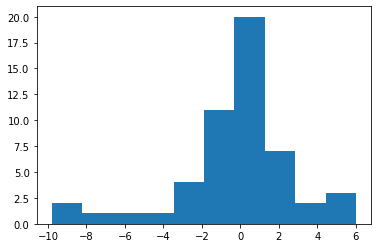

In [426]:
import matplotlib.pyplot as plt
plt.hist(df['%_change'])
plt.show()

In [427]:
from scipy.stats import t
from scipy.stats import norm
from scipy import stats

In [428]:
stat, p = shapiro(df['%_change'])
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably Gaussian')
else:
    print('Probably not Gaussian')

stat=0.886, p=0.000
Probably not Gaussian


<AxesSubplot:>

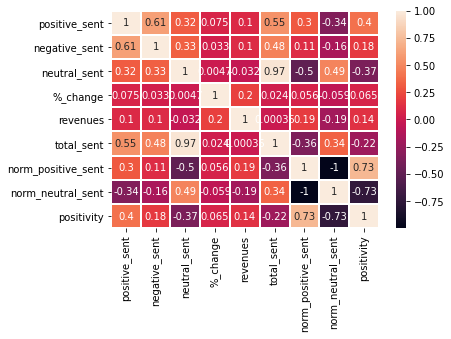

In [429]:
import seaborn as sns
sns.heatmap(df.corr(), annot = True, lw = 1)

In [430]:
X = df[['norm_positive_sent', 'negative_sent']]
y = df['%_change']
y = pd.to_numeric(y)

In [431]:
model = sm.OLS(y.astype(float), X.astype(float)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               %_change   R-squared (uncentered):                   0.002
Model:                            OLS   Adj. R-squared (uncentered):             -0.038
Method:                 Least Squares   F-statistic:                            0.05258
Date:                Sat, 13 Mar 2021   Prob (F-statistic):                       0.949
Time:                        16:43:07   Log-Likelihood:                         -130.36
No. Observations:                  52   AIC:                                      264.7
Df Residuals:                      50   BIC:                                      268.6
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
norm_positive_sent    -0.3534      1.120     -0.315      0.754      -2.604       1.897
negative_sent          0.2608      1.584      0.165      0.870      -2.920       3.442
==============================================================================
Omnibus:                       17.665   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.025
Skew:                          -1.153   Prob(JB):                     3.68e-06
Kurtosis:                       5.496   Cond. No.                         1.59
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [432]:
price_up = df[df['%_change']>0]
price_down = df[df['%_change']<=0]

In [433]:
price_up.median()

/Users/svetlana/opt/miniconda3/envs/finbert/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  """Entry point for launching an IPython kernel.


positive_sent         3.000000
negative_sent         0.000000
neutral_sent          7.000000
%_change              1.030097
revenues              1.785592
total_sent            9.000000
norm_positive_sent    0.333333
norm_neutral_sent     0.666667
positivity            0.400000
dtype: float64

In [434]:
price_down.median()

/Users/svetlana/opt/miniconda3/envs/finbert/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  """Entry point for launching an IPython kernel.


positive_sent          4.000000
negative_sent          0.000000
neutral_sent           7.000000
%_change              -1.325233
revenues               2.267372
total_sent            11.000000
norm_positive_sent     0.333333
norm_neutral_sent      0.666667
positivity             0.500000
dtype: float64

In [435]:
p_value = stats.mannwhitneyu(price_up['negative_sent'], price_down['negative_sent'])
print(p_value)

MannwhitneyuResult(statistic=313.5, pvalue=0.21820182667763355)


In [436]:
p_value = stats.mannwhitneyu(price_up['neutral_sent'], price_down['neutral_sent'])
print(p_value)

MannwhitneyuResult(statistic=301.5, pvalue=0.28028978038993235)


Статистически значимые различия в тональности между двумя выборками (рост цены в день объявления СП 
                                                                     и отсутствие роста цены)

In [437]:
price_up['positive_sent'].median()

3.0

In [438]:
price_down['positive_sent'].median()

4.0

In [439]:
p_value = stats.mannwhitneyu(price_up['positivity'], price_down['positivity'])
print(p_value)

MannwhitneyuResult(statistic=322.5, pvalue=0.4231799353733512)


In [440]:
price_up['positivity'].mean()

0.6752693205505927

In [441]:
price_down['positivity'].mean()

0.600804337034563

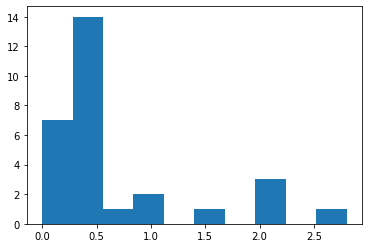

In [442]:
plt.hist(price_up['positivity'])
plt.show()

In [443]:
df.positivity.mean()

0.6423328855338872

In [444]:
higher_positivity = df[df['positivity']>0.5]
lower_positivity = df[df['positivity']<=0.5]

In [445]:
p_value = stats.mannwhitneyu(higher_positivity['%_change'], lower_positivity['%_change'])
print(p_value)

MannwhitneyuResult(statistic=263.0, pvalue=0.17101982665970555)


In [446]:
df['norm_positive_sent'].mean()

0.3403198506870737

In [447]:
negative = df[df['negative_sent']==1]
non_negative = df[df['negative_sent']==0]

In [448]:
p_value = stats.mannwhitneyu(negative['%_change'], non_negative['%_change'])
print(p_value)

MannwhitneyuResult(statistic=87.0, pvalue=0.38518490663182764)


In [449]:
price_up = df[df['%_change']>0.5]
no_price_change = df[df['%_change'].between (-0.5, 0.5)]
price_down = df[df['%_change']<-0.5]

In [450]:
stats.kruskal(price_up['neutral_sent'], no_price_change['neutral_sent'], 
              price_down['neutral_sent'])

KruskalResult(statistic=1.1031035165492395, pvalue=0.576055218013254)

In [451]:
no_price_change

,positive_sent,negative_sent,neutral_sent,ticker,date,%_change,revenues,total_sent,norm_positive_sent,norm_neutral_sent,positivity
3,5,0,21,RPT,2019-12-10,0.068401,-1.643502,26,0.192308,0.807692,0.238095
5,2,0,7,BWXT,2021-03-08,0.401676,0.753073,9,0.222222,0.777778,0.285714
6,4,0,11,INFY,2018-09-07,0.240390,2.547881,15,0.266667,0.733333,0.363636
16,8,0,2,HAL,2020-07-17,-0.076396,2.670348,10,0.800000,0.200000,4.000000
18,3,0,8,COO,2021-02-03,0.085308,0.888262,11,0.272727,0.727273,0.375000
22,3,0,3,RLGY,2017-02-15,0.073342,1.827931,6,0.500000,0.500000,1.000000
27,4,0,15,BA,2018-11-09,-0.385682,4.063163,19,0.210526,0.789474,0.266667
30,1,0,4,HR,2020-11-16,0.435864,-0.695426,5,0.200000,0.800000,0.250000
36,4,0,7,APD,2017-06-15,-0.240444,2.181129,11,0.363636,0.636364,0.571429
45,10,1,15,IBM,2019-01-17,0.468673,4.298930,26,0.384615,0.576923,0.625000


In [452]:
price_up.median()

/Users/svetlana/opt/miniconda3/envs/finbert/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  """Entry point for launching an IPython kernel.


positive_sent         3.000000
negative_sent         0.000000
neutral_sent          6.000000
%_change              1.415556
revenues              1.787591
total_sent            9.000000
norm_positive_sent    0.333333
norm_neutral_sent     0.666667
positivity            0.500000
dtype: float64

In [453]:
price_down.median()

/Users/svetlana/opt/miniconda3/envs/finbert/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  """Entry point for launching an IPython kernel.


positive_sent          4.000000
negative_sent          0.000000
neutral_sent           9.000000
%_change              -1.533329
revenues               2.161217
total_sent            11.000000
norm_positive_sent     0.333333
norm_neutral_sent      0.666667
positivity             0.500000
dtype: float64

In [454]:
no_price_change.median()

/Users/svetlana/opt/miniconda3/envs/finbert/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  """Entry point for launching an IPython kernel.


positive_sent          4.000000
negative_sent          0.000000
neutral_sent           7.000000
%_change               0.073342
revenues               2.181129
total_sent            11.000000
norm_positive_sent     0.266667
norm_neutral_sent      0.733333
positivity             0.363636
dtype: float64